In [1]:
# Import libraries and upload OHCO (by line) #
import pandas as pd
import numpy as np
import os
os.chdir('/Users/nickbruno/Documents/spring_2019/DS5559/project/code')

df = pd.read_csv('artist_song_verse_line_OHCO_df.csv') # includes corpus with no duplicate song names

In [2]:
artist_id_list = df.artist_id.unique().tolist()
import random
random.seed(8)
sub_artist = random.sample(artist_id_list, k=3)
sub_artist

[234, 381, 386]

In [3]:
# Subset to create smaller corpus #
subset_df = df[df.artist_id.isin(sub_artist)]

In [4]:
len(subset_df)

7470

In [5]:
subset_df = subset_df.set_index(['artist_id','song_id','verse_num','line_num'])
subset_df.head()

Line
artist_id song_id verse_num line_num                             
234       15233   0         0         I am a child in these hills
                            1                           I am away
                            2                          I am alone
                            3         I am a child in these hills
                            4               And looking for water

In [6]:
# Create a bag of tokens #
TOKEN_PAT = r'(\W+)'
token_subset_df = subset_df.Line.str.split(TOKEN_PAT, expand=True)\
    .stack()\
    .to_frame()\
    .rename(columns={0:'token_str'})
token_subset_df.index.names = ['artist_id','song_id','verse_num','line_num','token_num']

In [7]:
# Remove numbers and punctuation #
token_subset_df['punc'] = token_subset_df.token_str.str.match(r'^[\W_]*$').astype('int')
token_subset_df['num'] = token_subset_df.token_str.str.match(r'\d').astype('int')

In [8]:
# Create subsets where punc and num == 0
no_punc = token_subset_df[token_subset_df.punc == 0]
no_num = no_punc[no_punc.num == 0]

In [9]:
no_num.token_str = no_num.token_str.str.lower()

/anaconda3/lib/python3.7/site-packages/pandas/core/generic.py:4405: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[name] = value


In [10]:
# Remove stopwords #
from nltk.corpus import stopwords
stop = stopwords.words('english')

In [11]:
final_token_df = no_num[-no_num.token_str.isin(stop)]

In [12]:
final_token_df.head(10)

token_str  punc  num
artist_id song_id verse_num line_num token_num                     
234       15233   0         0        6             child     0    0
                                     12            hills     0    0
                            1        4              away     0    0
                            2        4             alone     0    0
                            3        6             child     0    0
                                     12            hills     0    0
                            4        2           looking     0    0
                                     6             water     0    0
                            5        2           looking     0    0
                                     6              life     0    0

In [13]:
final_token_df = final_token_df.drop(columns=['punc','num'])

In [14]:
df = final_token_df

In [15]:
import nltk
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
nltk.download('stopwords')
nltk.download('tagsets')
nltk.download('wordnet')

[nltk_data] Downloading package punkt to /Users/nickbruno/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /Users/nickbruno/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/nickbruno/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package tagsets to
[nltk_data]     /Users/nickbruno/nltk_data...
[nltk_data]   Package tagsets is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/nickbruno/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [16]:
# Stem each word #
stemmer = nltk.stem.porter.PorterStemmer()
df['port_stem'] = df.token_str.apply(lambda x: stemmer.stem(x))

In [17]:
token_counts = df.port_stem.str.lower().value_counts()
token_counts

like         388
know         296
love         247
got          234
one          211
come         204
go           198
time         190
get          187
see          186
way          174
make         163
want         153
babi         144
let          142
say          141
day          132
thing        130
look         129
feel         124
yeah         122
world        121
take         120
life         119
nigga        115
live         113
back         109
caus         107
night        105
good         103
            ... 
reput          1
goddamn        1
countless      1
spiral         1
soil           1
fleetwood      1
samachti       1
embryo         1
satan          1
pitcher        1
shift          1
rocket         1
postcard       1
hallow         1
bias           1
sniffin        1
arsti          1
foolish        1
niec           1
r              1
shma           1
beme           1
camp           1
zman           1
ce             1
bubba          1
burpin         1
rico          

In [18]:
vocab = df.port_stem.value_counts().to_frame()\
    .reset_index()\
    .rename(columns={'index':'port_stem', 'port_stem':'n'})
vocab = vocab.sort_values('port_stem').reset_index()
vocab.index.name = 'term_id'
vocab = vocab.drop('index', 1)

In [19]:
vocab.sort_values('n', ascending=False).head(25)

,port_stem,n
term_id,,
2228,like,388
2109,know,296
2289,love,247
1660,got,234
2656,one,211
759,come,204
1640,go,198
3942,time,190
1606,get,187


In [20]:
K = df
V = vocab

In [21]:
K['term_id'] = K['port_stem'].map(V.reset_index().set_index('port_stem').term_id).fillna(-1).astype('int')

In [22]:
OHCO = ['artist_id', 'song_id', 'verse_num', 'line_num','token_num']
SONG=OHCO[1:2]

In [23]:
# Create a bag of words per song #
BOW = K.groupby(SONG+['term_id'])['term_id'].count()
BOW.head()

song_id  term_id
15233    87         2
         172        2
         209        2
         625        1
         652        9
Name: term_id, dtype: int64

In [24]:
DTM = BOW.unstack().fillna(0)
DTM

term_id,0,1,2,3,4,5,6,7,8,9,...,4428,4429,4430,4431,4432,4433,4434,4435,4436,4437
song_id,,,,,,,,,,,,,,,,,,,,,
15233,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
15234,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
15235,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
15236,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
15237,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
15238,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
15239,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
15240,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
15241,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [25]:
# Now creating the TFIDF table #
alpha = .000001 # We introduce an arbitrary smoothing value
alpha_sum = alpha * V.shape[0]
TF = DTM.apply(lambda x: (x + alpha) / (x.sum() + alpha_sum), axis=1)

In [26]:
N_docs = DTM.shape[0]
V['df'] = DTM[DTM > 0].count()
TFIDF = TF * np.log2(N_docs / V['df'])

In [27]:
THM = -(TF * np.log2(TF))

In [28]:
TFTH = TF.apply(lambda x: x * THM.sum(), 1)

In [29]:
V['tf_sum'] = TF.sum()
V['tf_mean'] = TF.mean()
V['tf_max'] = TF.max()
V['tfidf_sum'] = TFIDF.sum()
V['tfidf_mean'] = TFIDF.mean()
V['tfidf_max'] = TFIDF.max()
V['tfth_sum'] = TFTH.sum()
V['tfth_mean'] = TFTH.mean()
V['tfth_max'] = TFTH.max()
V['th_sum'] = THM.sum()
V['th_mean'] = THM.mean()
V['th_max'] = THM.max()

In [30]:
V.sort_values(by='n', ascending=False)

,port_stem,n,df,tf_sum,tf_mean,tf_max,tfidf_sum,tfidf_mean,tfidf_max,tfth_sum,tfth_mean,tfth_max,th_sum,th_mean,th_max
term_id,,,,,,,,,,,,,,,
2228,like,388,113,2.289323,0.011562,0.090902,1.852469,0.009356,0.073556,27.755326,1.401784e-01,1.102076,12.123813,0.061231,0.314479
2109,know,296,117,2.263958,0.011434,0.102558,1.718325,0.008678,0.077841,27.078118,1.367582e-01,1.226651,11.960524,0.060407,0.336954
2289,love,247,73,2.362687,0.011933,0.320495,3.401163,0.017178,0.461362,23.621162,1.192988e-01,3.204172,9.997585,0.050493,0.526133
1660,got,234,85,1.465094,0.007399,0.063827,1.787364,0.009027,0.077866,12.021756,6.071594e-02,0.523728,8.205452,0.041442,0.253373
2656,one,211,94,1.576394,0.007962,0.239429,1.694257,0.008557,0.257331,12.946540,6.538657e-02,1.966373,8.212757,0.041479,0.493782
759,come,204,95,1.602286,0.008092,0.081629,1.697624,0.008574,0.086486,14.090508,7.116418e-02,0.717845,8.794002,0.044414,0.295070
1640,go,198,93,1.494269,0.007547,0.175665,1.629048,0.008228,0.191510,12.106129,6.114206e-02,1.423188,8.101708,0.040918,0.440761
3942,time,190,90,1.457824,0.007363,0.065569,1.658280,0.008375,0.074585,11.852574,5.986148e-02,0.533097,8.130320,0.041062,0.257741
1606,get,187,76,1.238989,0.006258,0.119395,1.711575,0.008644,0.164936,8.396512,4.240663e-02,0.809129,6.776907,0.034227,0.366087


In [31]:
# Find significant words #
TOPS = pd.DataFrame(index=range(10))
for m in ['tf','tfidf','th']:
    for n in ['mean','max']:
        key = '{}_{}'.format(m,n)
        TOPS[key] = V.sort_values(key, ascending=False).port_stem.head(10).tolist()

In [32]:
def get_songs(tokens, div_names, doc_str = 'term_id', sep='', flatten=False, 
             index_only=False):
    
    if not index_only:
        docs = tokens.groupby(div_names)[doc_str]\
          .apply(lambda x: x.str.cat(sep=sep))
        docs.columns = ['doc_content']
    else:
        docs = tokens.groupby(div_names)[doc_str].apply(lambda x: x.tolist())

    if flatten:
        docs = docs.reset_index().drop(div_names, 1)
    
    return docs

In [33]:
D = get_songs(K, SONG, 'port_stem', sep=" ")\
    .to_frame().rename(columns={'port_stem':'song_str'})

In [34]:
D['term_count'] = DTM.sum(1).astype('int').to_frame().rename(columns={0:'term_count'})
D['tf'] = D.term_count / D.term_count.sum()

In [36]:
D.head()

,song_str,term_count,tf
song_id,,,
15233,child hill away alon child hill look water loo...,59,0.002219
15234,long blind babi long long blind babi long litt...,98,0.003685
15235,everybodi talk readi leav light morn seen end ...,131,0.004926
15236,knock door look window babi knock door knock d...,78,0.002933
15237,word spoken somehow feel still right still con...,101,0.003798


In [37]:
song_ids = D.index.tolist()
pairs = [(i,j) for i in song_ids for j in song_ids if j > i]

In [38]:
P = pd.DataFrame(pairs).reset_index(drop=True).set_index([0,1])
P.index.names = ['doc_x','doc_y']

In [39]:
def euclidean(row):
    D1 = TFIDF.loc[row.name[0]]
    D2 = TFIDF.loc[row.name[1]]
    x = (D1 - D2)**2
    y = x.sum() 
    z = np.sqrt(y)
    return z

In [40]:
P['euclidean'] = 0
P['euclidean'] = P.apply(euclidean, 1)

In [41]:
P['euclidean_sim'] = 1 / (P.euclidean + 1)
PME = P.euclidean.unstack().fillna(0)
PME.head()

doc_y,15234,15235,15236,15237,15238,15239,15240,15241,15242,15243,...,26143,26144,26145,26146,26147,26148,26149,26150,26151,26152
doc_x,,,,,,,,,,,,,,,,,,,,,
15233,1.196448,1.138088,1.424194,1.086173,1.608350,1.300996,1.208127,1.365459,1.127044,1.056594,...,1.100855,1.227993,1.098492,1.150083,1.175917,1.087977,1.206505,1.074123,1.070496,1.053882
15234,0.000000,0.811419,1.156537,0.718468,1.395121,1.017833,0.907872,1.114161,0.796204,0.728015,...,0.730856,0.938252,0.763590,0.835504,0.855487,0.731857,0.909712,0.719261,0.710957,0.706075
15235,0.000000,0.000000,1.138084,0.678679,1.352474,0.970708,0.832610,1.060259,0.722803,0.628769,...,0.672515,0.881166,0.679767,0.761089,0.783901,0.650716,0.834624,0.640102,0.630772,0.612786
15236,0.000000,0.000000,0.000000,1.104135,1.603683,1.249272,1.199532,1.368734,1.119161,1.050496,...,1.087481,1.228456,1.095518,1.144663,1.168085,1.080357,1.196987,1.073613,1.063426,1.053735
15237,0.000000,0.000000,0.000000,0.000000,1.320983,0.907875,0.785718,0.993599,0.638661,0.552831,...,0.605740,0.834905,0.610863,0.699565,0.727103,0.585965,0.786397,0.562061,0.552735,0.539104


In [42]:
def cosine(row):
    D1 = TFIDF.loc[row.name[0]]
    D2 = TFIDF.loc[row.name[1]]
    x = D1 * D2
    y = x.sum()
    
#     a = np.sqrt(D1.sum()**2)     # <-- misplaced exponent!
#     b = np.sqrt(D2.sum()**2)     # <-- misplaced exponent!
#     c = np.sqrt(a) * np.sqrt(b)  # <-- extra square roots!

    a = np.sqrt((D1**2).sum())
    b = np.sqrt((D2**2).sum())
    c = a * b
    
    z = y / c
    return z

In [43]:
from numpy.linalg import norm
def cosine_np(row):
    D1 = TFIDF.loc[row.name[0]]
    D2 = TFIDF.loc[row.name[1]]
    return np.dot(D1, D2)/(norm(D1)*norm(D2))

from scipy import spatial
def cosine_scipy(row):
    D1 = TFIDF.loc[row.name[0]]
    D2 = TFIDF.loc[row.name[1]]
    return (1 - spatial.distance.cosine(D1, D2))

from sklearn.metrics.pairwise import cosine_similarity
def cosine_sklearn(row):
    D1 = TFIDF.loc[row.name[0]]
    D2 = TFIDF.loc[row.name[1]]
    return cosine_similarity([TFIDF.loc[0]], [TFIDF.loc[1]])[0][0]

In [44]:
# %%timeit -- 11.8 s ± 958 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
P['cosine'] = P.apply(cosine, 1)

# %%timeit -- 7.23 s ± 877 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
P['cosine_scipy'] = P.apply(cosine_scipy, 1)

# %%timeit -- 39.6 s ± 3.27 s per loop (mean ± std. dev. of 7 runs, 1 loop each)
#P['cosine_sklearn'] = P.apply(cosine_sklearn, 1)

# %%timeit -- 4.48 s ± 480 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
#P['cosine_np'] = P.apply(cosine_np, 1)

P.head()

euclidean  euclidean_sim        cosine  cosine_scipy
doc_x doc_y                                                      
15233 15234   1.196448       0.455280  1.089877e-02  1.089877e-02
      15235   1.138088       0.467708  3.106660e-02  3.106660e-02
      15236   1.424194       0.412508  1.585112e-02  1.585112e-02
      15237   1.086173       0.479347  6.605060e-02  6.605060e-02
      15238   1.608350       0.383384  5.334624e-07  5.334624e-07

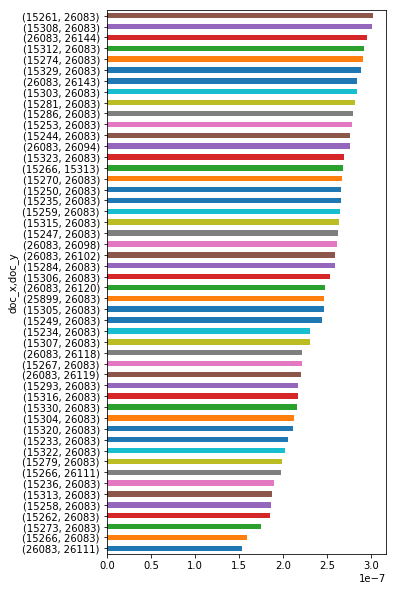

In [46]:
PMC = P.cosine.unstack().fillna(0)
PMC.head()
P.cosine.sort_values(ascending=True).head(50).plot(kind='barh', figsize=(5,10))

### All good until here. Now we want to find which songs are most similar to songs by other artists

In [47]:
# Create a dataframe that unstacks PMC #
pmc_df = PMC.unstack()

In [48]:
pmc_df = pd.DataFrame(pmc_df)

In [49]:
pmc_df.doc_y = pmc_df.index

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  """Entry point for launching an IPython kernel.


In [50]:
pmc_df = pmc_df.reset_index(level=['doc_y', 'doc_x'])

In [51]:
pmc_df = pmc_df.rename(columns={0:'Similarity'})

In [52]:
pmc_df.head()

,doc_y,doc_x,Similarity
0,15234,15233,0.010899
1,15234,15234,0.000000
2,15234,15235,0.000000
3,15234,15236,0.000000
4,15234,15237,0.000000


In [53]:
# read in data that includes the names of the songs and artists
artist_song_df = pd.read_csv('mallet_start_df.csv')
artist_song_df = artist_song_df.drop(columns=['Unnamed: 0', 'text'])
artist_song_df.head()

,artist,song,artist_id,song_id
0,ABBA,Ahe's My Kind Of Girl,0,0
1,ABBA,"Andante, Andante",0,1
2,ABBA,As Good As New,0,2
3,ABBA,Bang-A-Boomerang,0,3
4,ABBA,Burning My Bridges,0,4


### We want to find the artist and song name of each document

In [54]:
first_merge_df = pd.merge(pmc_df, artist_song_df, left_on='doc_y', right_on='song_id')

,doc_y,doc_x,Similarity,artist,song,artist_id,song_id
0,15234,15233,0.010899,Jackson Browne,Baby How Long,234,15234
1,15234,15234,0.000000,Jackson Browne,Baby How Long,234,15234
2,15234,15235,0.000000,Jackson Browne,Baby How Long,234,15234
3,15234,15236,0.000000,Jackson Browne,Baby How Long,234,15234
4,15234,15237,0.000000,Jackson Browne,Baby How Long,234,15234


In [55]:
first_merge_df = first_merge_df.rename(columns={'artist':'artist_y','song':'song_y','artist_id':'artist_id_y'})
first_merge_df = first_merge_df.drop(columns='song_id')

In [56]:
first_merge_df.head()

,doc_y,doc_x,Similarity,artist_y,song_y,artist_id_y
0,15234,15233,0.010899,Jackson Browne,Baby How Long,234
1,15234,15234,0.000000,Jackson Browne,Baby How Long,234
2,15234,15235,0.000000,Jackson Browne,Baby How Long,234
3,15234,15236,0.000000,Jackson Browne,Baby How Long,234
4,15234,15237,0.000000,Jackson Browne,Baby How Long,234


In [57]:
second_merge_df = pd.merge(first_merge_df, artist_song_df, left_on='doc_x', right_on='song_id')

In [58]:
second_merge_df = second_merge_df.rename(columns={'artist':'artist_x','song':'song_x','artist_id':'artist_id_x'})
second_merge_df = second_merge_df.drop(columns='song_id')
    # This creates the final dataframe with artist and song of both songs

In [59]:
# Take a peak at the most similar songs #
second_merge_df.sort_values('Similarity',ascending=False).head(10)
    # interesting that the most similar songs are likely by different artists

,doc_y,doc_x,Similarity,artist_y,song_y,artist_id_y,artist_x,song_x,artist_id_x
32473,26121,26119,0.714658,Outkast,Love In War,386,Outkast,Love And War,386
11484,15292,15291,0.336620,Jackson Browne,Doolin-dalton (Reprise),234,Jackson Browne,Doolin-dalton,234
6760,15296,15267,0.326727,Jackson Browne,For America,234,Jackson Browne,When The Stone Begins To Turn,234
11889,15303,15293,0.296054,Jackson Browne,Here Come Those Tears Again,234,Jackson Browne,Enough Of The Night,234
12677,15303,15297,0.282763,Jackson Browne,Here Come Those Tears Again,234,Jackson Browne,For Taking The Trouble,234
14079,15326,15304,0.281941,Jackson Browne,Sky Blue And Black,234,Jackson Browne,Hold On Hold Out,234
30893,26117,26111,0.267377,Outkast,Land Of A Million Drums,386,Outkast,Idlewild Blue,386
9924,15308,15283,0.261413,Jackson Browne,In The Shape Of A Heart,234,Jackson Browne,Casino Nation,234
8649,26134,15276,0.259868,Outkast,She's Alive,386,Jackson Browne,Alive In The World,234
16538,26143,15316,0.259714,Outkast,The Way You Move,386,Jackson Browne,"Love Me, Lovely",234


In [60]:
# Now I want to compare the similarities between different artists #
diff_artist_sim_df = second_merge_df.loc[~(second_merge_df['artist_id_y'] == second_merge_df['artist_id_x'])]

In [67]:
diff_artist_sim_df.sort_values('Similarity', ascending=False).head(10)

,doc_y,doc_x,Similarity,artist_y,song_y,artist_id_y,artist_x,song_x,artist_id_x
8649,26134,15276,0.259868,Outkast,She's Alive,386,Jackson Browne,Alive In The World,234
16538,26143,15316,0.259714,Outkast,The Way You Move,386,Jackson Browne,"Love Me, Lovely",234
16535,26140,15316,0.251368,Outkast,Stankonia,386,Jackson Browne,"Love Me, Lovely",234
16515,26120,15316,0.220686,Outkast,Love Hater,386,Jackson Browne,"Love Me, Lovely",234
14751,26129,15307,0.201396,Outkast,Pink And Blue,386,Jackson Browne,I'm The Cat,234
9237,26131,15279,0.194917,Outkast,Reset,386,Jackson Browne,Anything Can Happen,234
370,26129,15234,0.184929,Outkast,Pink And Blue,386,Jackson Browne,Baby How Long,234
7630,26100,15271,0.183708,Outkast,Funky Ride,386,Jackson Browne,YOUR BRIGHT BABY BLUES,234
7877,26150,15272,0.172909,Outkast,What About Your Friends (Extended Remix),386,Jackson Browne,You're A Friend Of Mine,234
18686,26124,15327,0.172837,Outkast,Mutron Angel,386,Jackson Browne,Soldier Of Plenty,234


In [68]:
highest_similarities = diff_artist_sim_df.groupby('doc_y')[['Similarity']].max().sort_values('Similarity',ascending=False)
highest_similarities = highest_similarities.reset_index(level=['doc_y'])
highest_similarities.head(10)

,doc_y,Similarity
0,26134,0.259868
1,26143,0.259714
2,26140,0.251368
3,26120,0.220686
4,26129,0.201396
5,26131,0.194917
6,26100,0.183708
7,26150,0.172909
8,26124,0.172837
9,26127,0.164837


In [63]:
highest_similarities.shape[0] # final dataframe should have 184 songs

197

In [64]:
highest_similarities.tail(10)

,doc_y,Similarity
187,15297,0.0
188,15298,0.0
189,15299,0.0
190,15300,0.0
191,15301,0.0
192,15302,0.0
193,15303,0.0
194,15304,0.0
195,15305,0.0
196,15332,0.0


In [65]:
len(highest_similarities[highest_similarities.Similarity == 0]) # half of the songs have no similarity?
    # THIS IS AN ISSUE. WHAT IS GOING WRONG?

107

### Now merge the 'highest_similarities' df with 'diff_artist_sim_df'
#### Final dataframe should only have 197 rows